<a href="https://colab.research.google.com/github/adnaneaabbar/stock-trading-system/blob/master/stock_trading_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nous allons tout d'abord faire l'étude, sur la banque d'investissement GS - Goldman Sachs Inc. Nous allons essayer de prédire à l'aide de séries chronologiques les prix de leurs actions.

---

# Etude à base de modèle LSTM


---

## Etape 1 : Chargement et analyse des données.

Nous utiliserons les données historiques des 10 dernières années du cours des actions de GS. Vous pouvez trouver les données sur yahoo finance.


In [0]:
import numpy as np
import pandas as pd 

In [0]:
url = 'https://raw.githubusercontent.com/adnaneaabbar/stock-trading-system/master/data/goldman_sachs.csv'
gs = pd.read_csv(url)

In [3]:
gs.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,167.289993,170.130005,166.929993,168.839996,146.078110,6401800
1,2010-01-04,170.050003,174.250000,169.509995,173.080002,149.746597,9135000
2,2010-01-05,173.000000,176.259995,172.570007,176.139999,152.394012,11659400
3,2010-01-06,175.380005,175.380005,173.759995,174.259995,150.767426,7381100
4,2010-01-07,174.320007,178.750000,173.949997,177.669998,153.717728,8727400


In [4]:
gs.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2260,2018-12-24,159.000000,160.000000,154.309998,156.350006,152.260864,3783500
2261,2018-12-26,157.000000,163.110001,151.699997,162.929993,158.668777,7054700
2262,2018-12-27,160.119995,165.410004,159.020004,165.410004,161.083923,4973000
2263,2018-12-28,165.639999,165.949997,162.020004,163.029999,158.766159,4110500
2264,2018-12-31,163.779999,167.119995,163.779999,167.050003,162.681030,4550000



Comme vous pouvez le voir, il y a 2265 lignes, chacune représentant les attributs boursiers d'une journée pour la banque. Traçons les différents attributs :

<Figure size 432x288 with 0 Axes>

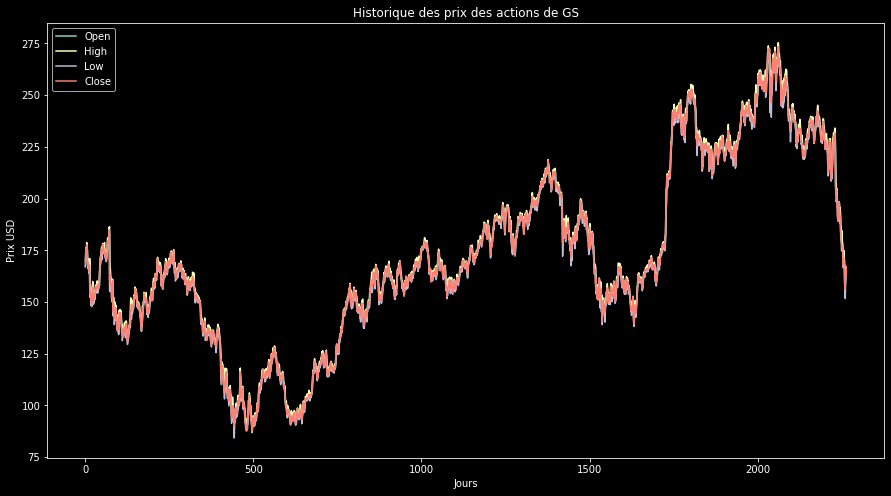

In [5]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use('dark_background')

plt.figure()
plt.figure(figsize=(15,8))
plt.plot(gs["Open"])
plt.plot(gs["High"])
plt.plot(gs["Low"])
plt.plot(gs["Close"])
plt.title('Historique des prix des actions de GS')
plt.ylabel('Prix USD')
plt.xlabel('Jours')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()


Les prix - Open, Close, Low, High - ne varient pas trop les uns des autres, sauf occasionnellement. Traçons le Volume:

<Figure size 432x288 with 0 Axes>

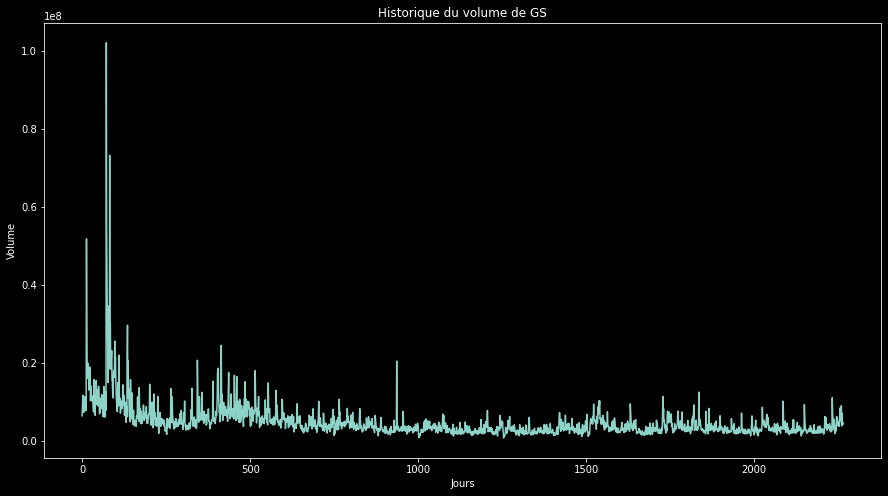

In [6]:
plt.figure()
plt.figure(figsize=(15,8))
plt.plot(gs["Volume"])
plt.title('Historique du volume')
plt.ylabel('Volume')
plt.xlabel('Jours')
plt.show()

Il y a une forte augmentation du nombre de transactions autour du 80ème jour sur la chronologie, qui coïncide avec la chute soudaine du cours des actions just après quelques jours.


Après avoir chargé les données, nous nous assurons que toutes les données sont présentes, lorsqu'une donnée n'existe pas, elle est remplacée par la valeur null ou NaN.

In [8]:
gs.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Comme nous pouvons voir toutes les valeurs existent et de type int64.

## Etape 2 : Normalisation des données.

Les données ne sont pas normalisées et la plage pour chaque colonne varie, en particulier le volume. La normalisation des données aide l'algorithme à converger, c'est-à-dire à trouver efficacement le minimum local / global. 


Nous utiliserons MinMaxScaler de Sci-kit Learn. Mais avant cela, nous devons diviser l'ensemble de données en ensembles de données d'apprentissage(**training**) et de **test**. Je vais également convertir le *DataFrame* en *ndarray* dans le processus.


In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# definir les colonnes qu'on va nourrir à notre modèle d'apprentissage
train_cols = ["Open","High","Low","Close","Volume"]

# nous voulons 80% des données en training et les 20% qui restent pour tester le modèle sur des données qu'il n'a pas encore appris
gs_train, gs_test = train_test_split(gs, train_size=0.8, test_size=0.2, shuffle=False)

# regarder la forme de nos données, leur taille..
print(gs_train.shape)
print(gs_test.shape)

# redimensionnement pour garder les colonnes qui nous interéssent
x = gs_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(gs_test.loc[:,train_cols])

print(x_train.shape)
print(x_test.shape)

(1812, 7)
(453, 7)
(1812, 5)
(453, 5)
